In [6]:
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord,SphericalDifferential,ICRS,Galactic,GalacticLSR,Distance,Galactocentric
import pandas as pd
import matplotlib.cm as cm
from astropy.table import Table, join,vstack
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits
from scipy import ndimage, interpolate
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
import scipy.constants
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams["mathtext.fontset"] = 'stix'
%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [7]:
import sys
sys.path.insert(1, '/Users/anniegao/Documents/Research/Gum Nebula Project/')
import get_property as gp

In [3]:
# cluster_all = fits.open('/Users/anniegao/Dropbox/Gum_Nebula/data/Zeta_Pup_vicinity/asu-2.fit')[1].data
cluster_all = pd.read_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/cluster_sample_data_Swiggum2024.csv')
ivs = pd.read_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/npix128boundary_mean_sigma10.csv')
ivs_out = pd.read_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/npix128boundaryout_mean_sigma10.csv')
peakxyz= pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/peaks_meanmap_xyz.csv')

gum_cenx0 = -67 
gum_ceny0 = -334
gum_cenz0 = -65

gum_cenx = -67 # averaged by result
gum_ceny = -337
gum_cenz = -61

In [4]:
U_sun, V_sun, W_sun = 11.1, 12.24, 7.25
o_obs_future = Orbit([0,0,0,U_sun*-1, V_sun*-1, W_sun*-1], lb=True,uvw=True)
ts_future = np.arange(0,3.005,0.01)*u.Myr
ts_past = np.arange(-3,0.005,0.01)*u.Myr
o_obs_future.integrate(ts_future, MWPotential2014)
o_obs_past = o_obs_future.flip(inplace=False)
o_obs_past.integrate(ts_past,MWPotential2014)

In [5]:
#get past xyz coordinates for the observer at the LSR position
#galpy needs values in kpc so we convert to pc by multiplying by 1000
obs_x_past = (o_obs_past.helioX(ts_past) * 1000.)[::-1]
obs_y_past = (o_obs_past.helioY(ts_past) * 1000.)[::-1]
obs_z_past = (o_obs_past.helioZ(ts_past) * 1000.)[::-1]

In [6]:
def trace(coord): #temporarily use,need to pre-define the ts_past, ts_future
    o_obj_future = Orbit(coord)
    o_obj_future.integrate(ts_future, MWPotential2014)
    o_obj_past = o_obj_future.flip(inplace=False)
    o_obj_past.integrate(ts_past, MWPotential2014)
    x_past_obj = np.flip((o_obj_past.helioX(ts_past) * 1000.), axis=-1)
    y_past_obj = np.flip((o_obj_past.helioY(ts_past) * 1000.), axis=-1)
    z_past_obj = np.flip((o_obj_past.helioZ(ts_past) * 1000.), axis=-1)
    x_orbit_obj = x_past_obj - obs_x_past
    y_orbit_obj = y_past_obj - obs_y_past
    z_orbit_obj = z_past_obj - obs_z_past
    return x_orbit_obj, y_orbit_obj, z_orbit_obj

In [ ]:
cluster_near = cluster_all[(cluster_all['x_helio']<gum_cenx+200)&(cluster_all['x_helio']>gum_cenx-200)&(cluster_all['y_helio']<gum_ceny+200)&(cluster_all['y_helio']>gum_ceny-200)&(cluster_all['z_helio']<gum_cenz+200)&(cluster_all['z_helio']>gum_cenz-200)]

In [9]:
cl_all_ra = cluster_near['ra'].values#cluster_near['RA_ICRS']
cl_all_dec = cluster_near['dec'].values#cluster_near['DE_ICRS']
cl_all_plx = cluster_near['parallax'].values #cluster_near['Plx']
cl_all_pmra = cluster_near['pmra'].values #cluster_near['pmRA']
cl_all_pmdec = cluster_near['pmdec'].values #cluster_near['pmDE']
cl_all_rv = cluster_near['rv_combined'].values #cluster_near['RV']

In [ ]:
cluster_coord = SkyCoord(u=cluster_near['x_helio'].values*u.pc, v=cluster_near['y_helio'].values*u.pc, w=cluster_near['z_helio'].values*u.pc,
                         U=cluster_near['U'].values*u.km/u.s, V=cluster_near['V'].values*u.km/u.s, W=cluster_near['W'].values*u.km/u.s, 
                         frame='galactic', representation_type='cartesian')
x_orbit_cluster_past, y_orbit_cluster_past,z_orbit_cluster_past = trace(cluster_coord)

## Selecting clusters

In [13]:
# distance between the clusters and the center of the Gum
dist_cl_gum = np.sqrt((np.ones_like(x_orbit_cluster_past)*gum_cenx-x_orbit_cluster_past)**2+
                     (np.ones_like(y_orbit_cluster_past)*gum_ceny-y_orbit_cluster_past)**2+
                     (np.ones_like(z_orbit_cluster_past)*gum_cenz-z_orbit_cluster_past)**2)

### Limits: distance, age, memberships

In [ ]:
# with Gum_center: min dist among past 3Myr
min_Gumdist_samples = np.min(dist_cl_gum, axis=1)
# the min dist among the n_cl_sample
age_lim = 40 #38 #Myr
dist_lim = 80 
# time_lim = -0.01*3 #Myr, not homogeneously decreasing
N_member_lim = 150
mask_Gum = (min_Gumdist_samples<dist_lim) & (10**cluster_near['log_age_50']/1e6<age_lim) &(cluster_near['n_stars']>N_member_lim) #&(min_Gumdist_time.value<time_lim)
cl1 = cluster_near[mask_Gum]

cl1['name']

14         Alessi_36
15             BH_23
34         CWNU_1044
56     Collinder_135
57     Collinder_140
139         NGC_2547
146        NGC_2451B
156          OC_0450
157          OC_0470
172          OCSN_82
181          Pozzo_1
Name: name, dtype: object

In [15]:
x_cl_select, y_cl_select, z_cl_select = x_orbit_cluster_past[mask_Gum], y_orbit_cluster_past[mask_Gum], z_orbit_cluster_past[mask_Gum]

In [ ]:
for cluster in range(len(cl1)):
    name = cl1['name'].values[cluster]
    cluster_table = Table()
    cluster_table['time'] = ts_past
    cluster_table['x_past[pc]'] = x_cl_select[cluster]
    cluster_table['y_past[pc]'] = y_cl_select[cluster]
    cluster_table['z_past[pc]'] = z_cl_select[cluster]
    # cluster_table.write(f'/Users/anniegao/Documents/dustmaps_files/Traces/Gum_vicinity_clusters/Updated_paths_Swiggum/{name}.csv', format='csv')

## Check the selected members in Gamma Vel family

In [ ]:
cl_gamma_vel_name = ['Pozzo_1','OC_0470', 'CWNU_1083', 'CWNU_1096',  'OC_0479']
for cluster in range(2, len(cl_gamma_vel_name)): #only the ones not already exported
    name = cl_gamma_vel_name[cluster]
    cl_info = cluster_near[cluster_near['name'].values==name]
    cluster_table = Table()
    cluster_table['time'] = ts_past
    cluster_table['x_past[pc]'] = x_orbit_cluster_past[cluster_near['name'].values==name][0,:]
    cluster_table['y_past[pc]'] = y_orbit_cluster_past[cluster_near['name'].values==name][0,:]
    cluster_table['z_past[pc]'] = z_orbit_cluster_past[cluster_near['name'].values==name][0,:]
    # cluster_table.write(f'/Users/anniegao/Documents/dustmaps_files/Traces/Gum_vicinity_clusters/Updated_paths_Swiggum/{name}.csv', format='csv')

## Table of all the relevant clusters

In [24]:
cluster_table = Table(names=('age[Myr]', 'x_helio[pc]','y_helio[pc]', 'z_helio[pc]', 
                                  'U_helio[km/s]', 'V_helio[km/s]', 'W_helio[km/s]'))

total_cl = ['Pozzo_1', 'CWNU_1083', 'CWNU_1096', 'OC_0470', 'OC_0479', 'Trumpler_10', 'OC_0450', 'NGC_2451B', 'Collinder_135','Collinder_140','OCSN_82', 'Alessi_36']
for cluster in range(len(total_cl)):
    name = total_cl[cluster]
    cl_info = cluster_near[cluster_near['name'].values==name]
    cluster_table.add_row([10**cl_info['log_age_50']/1e6, cl_info['x_helio'].values,  cl_info['y_helio'].values, cl_info['z_helio'].values,
                            cl_info['U'].values, cl_info['V'].values, cl_info['W'].values])
cluster_table.add_column(['Pozzo_1', 'CWNU_1083', 'CWNU_1096', 'OC_0470', 'OC_0479', 'Trumpler_10', 'OC_0450', 'NGC_2451B', 'Collinder_135','Collinder_140','OCSN_82', 'Alessi_36'], name='Name')

In [29]:
cluster_table.add_row([3.2, zp_cartesian.u.value, zp_cartesian.v.value,zp_cartesian.w.value,
                           zp_cartesian.U.value, zp_cartesian.V.value, zp_cartesian.W.value, 'zeta pup'])

In [ ]:
# cluster_table.write('/Users/anniegao/Dropbox/Gum_Nebula/data/all_cluster_info.csv', format='csv')

## Neutron Star

In [21]:
ns_path=pd.read_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/NS_-105rv.csv')

In [22]:
ns_coord = SkyCoord(ra='07h20m24.9620s', dec='-31d25m50.083s', distance=Distance(parallax= 3.6*u.mas),
                    pm_ra_cosdec= -92.8*u.mas/u.yr, pm_dec= 55.3*u.mas/u.yr, radial_velocity=0*u.km/u.s,
                    frame='icrs')

In [25]:
ns_cartesian = ns_coord.transform_to(Galactic)
ns_cartesian.representation_type= 'cartesian'
cluster_table.add_row([0, ns_cartesian.u.value, ns_cartesian.v.value,ns_cartesian.w.value,
                           ns_cartesian.U.value, ns_cartesian.V.value, ns_cartesian.W.value, 'NS'])

In [240]:
gamma2cartesian = Gamma2Vel.transform_to(Galactic)
gamma2cartesian.representation_type= 'cartesian'
cluster_table.add_row([5,  gamma2cartesian.u.value, gamma2cartesian.v.value,gamma2cartesian.w.value,
                           gamma2cartesian.U.value, gamma2cartesian.V.value, gamma2cartesian.W.value, 'Gamma2 Vel'])

## Trumpler 10

In [144]:
tr10_info = cluster_near[cluster_near['Name']=='Trumpler_10']
Trumpler_10_clinfo = SkyCoord(ra=tr10_info['RA_ICRS']*u.deg, dec=tr10_info['DE_ICRS']*u.deg, distance=Distance(parallax=tr10_info['Plx']*u.mas),
                         pm_ra_cosdec=tr10_info['pmRA']*u.mas/u.yr, pm_dec=tr10_info['pmDE']*u.mas/u.yr,
                         radial_velocity=tr10_info['RV']*u.km/u.s, frame='icrs')


In [145]:
x_orbit_tr10_past, y_orbit_tr10_past, z_orbit_tr10_past = trace(Trumpler_10_clinfo)

In [159]:
tr10_table = Table()
tr10_table['time'] = ts_past
tr10_table['x_past[pc]'] = x_orbit_tr10_past[0,:]
tr10_table['y_past[pc]'] = y_orbit_tr10_past[0,:]
tr10_table['z_past[pc]'] = z_orbit_tr10_past[0,:]
# tr10_table.write('/Users/anniegao/Dropbox/Gum_Nebula/data/Zeta_Pup_vicinity/Trumpler_10_coords.csv', format='csv')

In [21]:
tr10_cartesian = Trumpler_10_clinfo.transform_to(Galactic)
tr10_cartesian.representation_type = 'cartesian'
tr10_cartesian

<SkyCoord (Galactic): (u, v, w) in pc
    [(-54.31256927, -432.23788725, 4.5575167)]
 (U, V, W) in km / s
    [(-28.92293096, -16.63697314, -11.15005502)]>

## $\zeta$ Puppis

In [26]:
from astroquery.vizier import Vizier
v = Vizier(columns=["**"], catalog="I/311/hip2")
zeta=v.query_object("zeta puppis")

In [27]:
zp_ra = zeta[0]['RArad'].value
zp_dec = zeta[0]['DErad'].value
zp_plx =zeta[0]['Plx'].value
zp_pmra = zeta[0]['pmRA'].value
zp_pmdec = zeta[0]['pmDE'].value
zp_rv = -25.4
zp_coord = SkyCoord(ra=zp_ra*u.deg, dec=zp_dec*u.deg, distance=Distance(parallax=zp_plx*u.mas),
                    pm_ra_cosdec=zp_pmra*u.mas/u.yr, pm_dec=zp_pmdec*u.mas/u.yr,
                    radial_velocity=zp_rv*u.km/u.s, frame='icrs')

In [28]:
zp_cartesian = zp_coord.transform_to(Galactic)
zp_cartesian.representation_type='cartesian'
zp_cartesian

<SkyCoord (Galactic): (u, v, w) in pc
    [(-80.23662039, -321.23715205, -27.25471738)]
 (U, V, W) in km / s
    [(-38.97099582, 38.01221691, -23.68388793)]>

In [155]:
x_orbit_zp_past, y_orbit_zp_past,z_orbit_zp_past = trace(zp_coord)


In [160]:
zp_table = Table()
zp_table['time'] = ts_past
zp_table['x_past[pc]'] = x_orbit_zp_past[0,:]
zp_table['y_past[pc]'] = y_orbit_zp_past[0,:]
zp_table['z_past[pc]'] = z_orbit_zp_past[0,:]
# zp_table.write('/Users/anniegao/Dropbox/Gum_Nebula/data/Zeta_Pup_vicinity/Zeta_Pup_coords.csv', format='csv')

## Distance between Trumpler 10 and Zeta Pup

In [101]:
n_sample = 10000
tr10_ra = tr10_info['RA_ICRS']*np.ones(n_sample)
tr10_dec = tr10_info['DE_ICRS']*np.ones(n_sample)
tr10_plx = np.random.normal(loc=tr10_info['Plx'], scale=tr10_info['s_Plx'],size=n_sample)
tr10_pmra = np.random.normal(loc=tr10_info['pmRA'], scale=tr10_info['s_pmRA'], size=n_sample)
tr10_pmdec =np.random.normal(loc=tr10_info['pmDE'], scale=tr10_info['s_pmDE'], size=n_sample)
tr10_rv = np.random.normal(loc=tr10_info['RV'], scale=tr10_info['s_RV'], size=n_sample)
zp_ra = zeta[0]['RArad'].value*np.ones(n_sample)
zp_dec = zeta[0]['DErad'].value*np.ones(n_sample)
zp_plx = np.random.normal(loc=zeta[0]['Plx'].value, scale=zeta[0]['e_Plx'].value, size=n_sample)
zp_pmra = np.random.normal(loc=zeta[0]['pmRA'].value, scale=zeta[0]['e_pmRA'].value, size=n_sample)
zp_pmdec = np.random.normal(loc=zeta[0]['pmDE'].value, scale=zeta[0]['e_pmDE'].value, size=n_sample)
zp_rv = np.random.normal(loc=-25.4, scale=2.1, size=n_sample)

In [103]:
tr10_coord = SkyCoord(ra=tr10_ra*u.deg, dec=tr10_dec*u.deg, distance=Distance(parallax=tr10_plx*u.mas),
                      pm_ra_cosdec=tr10_pmra*u.mas/u.yr, pm_dec=tr10_pmdec*u.mas/u.yr,
                      radial_velocity=tr10_rv*u.km/u.s, frame='icrs')
zp_coord = SkyCoord(ra=zp_ra*u.deg, dec=zp_dec*u.deg, distance=Distance(parallax=zp_plx*u.mas),
                    pm_ra_cosdec=zp_pmra*u.mas/u.yr, pm_dec=zp_pmdec*u.mas/u.yr,
                    radial_velocity=zp_rv*u.km/u.s, frame='icrs')
x_orbit_tr10, y_orbit_tr10, z_orbit_tr10 = trace(tr10_coord)
x_orbit_zp, y_orbit_zp, z_orbit_zp = trace(zp_coord)

In [104]:
# d_tr10_zp = np.sqrt((x_orbit_tr10_past-x_orbit_zp_past)**2 + (y_orbit_tr10_past- y_orbit_zp_past)**2 +(z_orbit_tr10_past-z_orbit_zp_past)**2)
dist_tr10_zp_nsample= np.sqrt((x_orbit_tr10-x_orbit_zp)**2+(y_orbit_tr10-y_orbit_zp)**2+(z_orbit_tr10-z_orbit_zp)**2)

In [112]:
min_dist_sample = np.min(dist_tr10_zp_nsample, axis=1)
min_dist_time = ts_past[np.argmin(dist_tr10_zp_nsample, axis=1)].value
print(np.percentile(min_dist_sample, 50), np.percentile(min_dist_sample, 2.5)-np.percentile(min_dist_sample, 50), np.percentile(min_dist_sample, 97.5)-np.percentile(min_dist_sample, 50))
print(np.percentile(min_dist_time, 50), np.percentile(min_dist_time, 2.5)-np.percentile(min_dist_time, 50), np.percentile(min_dist_time, 97.5)-np.percentile(min_dist_time, 50))

9.659439107615064 -8.214493120228504 14.993555148649996
-2.020000000000021 -0.9799999999999791 0.6999999999999851


In [110]:
np.min(dist_tr10_zp_nsample)

0.17397705528668916

## When $\zeta$ Puppis pass by XX pc of IVS center at YY Myr ago

In [117]:
dist_zp_ivs = np.sqrt((x_orbit_zp[0, :]-gum_cenx)**2+(y_orbit_zp[0, :]-gum_ceny)**2+(z_orbit_zp[0, :]-gum_cenz)**2)
dist_zpmean_ivs = np.sqrt((x_orbit_zp_past[0, :]-gum_cenx)**2+(y_orbit_zp_past[0, :]-gum_ceny)**2+(z_orbit_zp_past[0, :]-gum_cenz)**2)

In [119]:
print(np.min(dist_zpmean_ivs), ts_past[np.argmin(dist_zpmean_ivs)])

38.20663462674936 -0.17000000000006033 Myr


## Gamma2 Vel

In [239]:
Gamma2Vel= SkyCoord(ra='08h09m31.95013s',dec='-47d20m11.7108s', distance=(1000/2.92)*u.pc,pm_ra_cosdec=-6.07*u.mas/u.yr,pm_dec=10.43*u.mas/u.yr, radial_velocity=15.00*u.km/u.s,frame='icrs')
x_orbit_gamma2Vel, y_orbit_gamma2Vel, z_orbit_gamma2Vel = trace(Gamma2Vel)

In [171]:
g2vel_table = Table()
g2vel_table['time'] = ts_past
g2vel_table['x_past[pc]'] = x_orbit_gamma2Vel
g2vel_table['y_past[pc]'] = y_orbit_gamma2Vel
g2vel_table['z_past[pc]'] = z_orbit_gamma2Vel
# g2vel_table.write('/Users/anniegao/Dropbox/Gum_Nebula/data/gamma2Vel.csv', format='csv')

## NS Path

In [161]:
ns_coord = SkyCoord(ra='07h20m24.9620s', dec='-31d25m50.083s', distance=Distance(parallax= 3.6*u.mas),
                    pm_ra_cosdec= -92.8*u.mas/u.yr, pm_dec= 55.3*u.mas/u.yr, radial_velocity=0*u.km/u.s,
                    frame='icrs')
ns_coord_table = gp.calculate_properties(ns_coord)
ns_coord_table['plx_std'] = 1.6
ns_coord_table['pmRA_std'] = 1.2
ns_coord_table['pmDE_std'] = 1.3

In [121]:
n_sample = 10000
ns_ra = ns_coord.ra.value*np.ones(n_sample)
ns_dec = ns_coord.dec.value*np.ones(n_sample)
ns_plx = np.random.normal(loc=3.6, scale=1.6, size=n_sample)
ns_pmra = np.random.normal(loc=-92.8, scale=1.2, size=n_sample) #-92.8*np.ones(n_sample)      #
ns_pmdec = np.random.normal(loc=55.3, scale=1.3, size=n_sample) #55.3*np.ones(n_sample) 
ns_rv = np.random.uniform(-500, 500, n_sample) #np.linspace(-500, 500, n_sample)  #
ns_coord = SkyCoord(ra=ns_ra*u.deg, dec=ns_dec*u.deg, distance=Distance(parallax=np.abs(ns_plx)*u.mas),
                    pm_ra_cosdec=ns_pmra*u.mas/u.yr, pm_dec=ns_pmdec*u.mas/u.yr,
                    radial_velocity=ns_rv*u.km/u.s, frame='icrs')
x_orbit_ns, y_orbit_ns, z_orbit_ns = trace(ns_coord)

In [122]:
ns_pix = hp.vec2pix(128, x_orbit_ns - gum_cenx0, y_orbit_ns - gum_ceny0, z_orbit_ns - gum_cenz0)
d_cen0 = np.sqrt((x_orbit_ns - gum_cenx0)**2 +  (y_orbit_ns - gum_ceny0)**2 + (z_orbit_ns - gum_cenz0)**2)
idx = np.where(d_cen0 < ivs['r_raw'].values[ns_pix]) # the cases where NS path inside the shell
idx_sample, idx_t = idx[0], idx[1]
# sample index: idx[0]; time step index: idx[1] --> choose ones within 3 Myr
ns_chosen_x = x_orbit_ns[np.unique(idx_sample)]
ns_chosen_y = y_orbit_ns[np.unique(idx_sample)]
ns_chosen_z = z_orbit_ns[np.unique(idx_sample)]

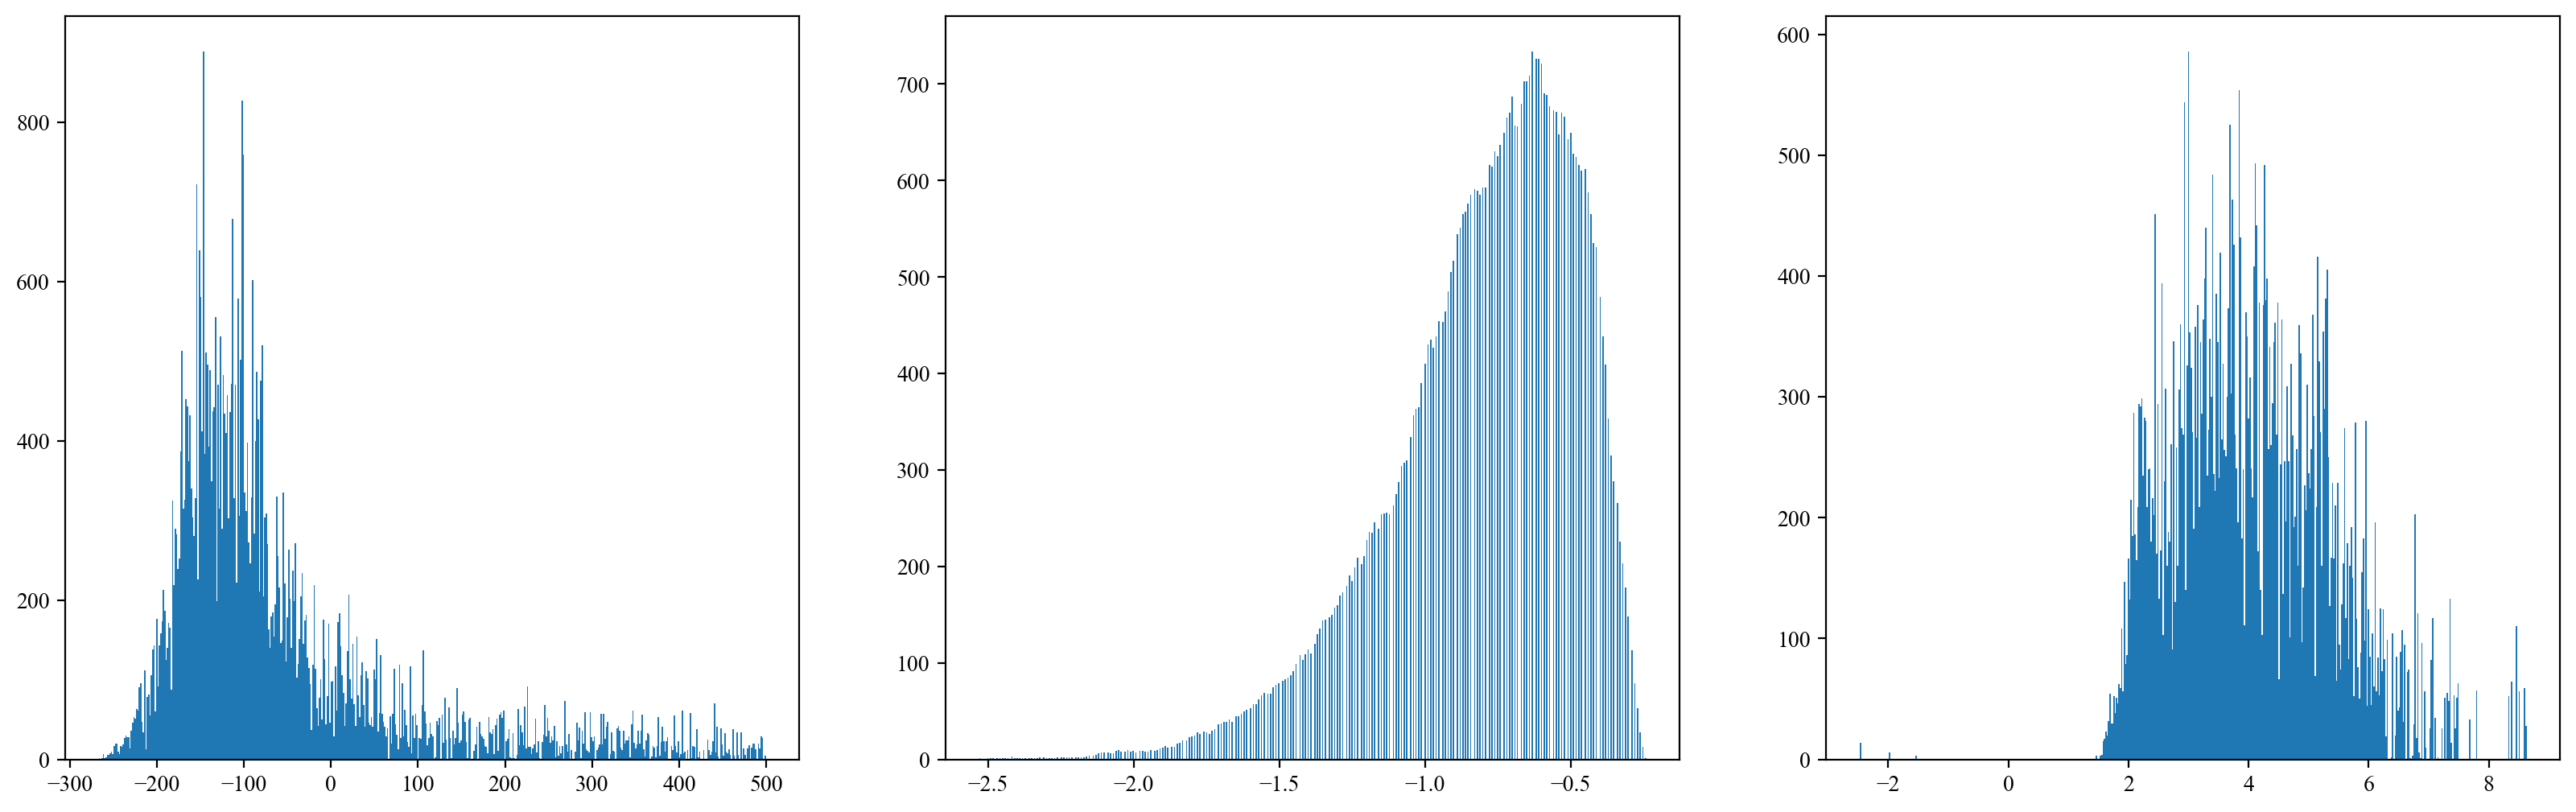

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6)) 
size=0.03
size_p = 2
alpha = 0.05
fontsize = 18
cmap=cm.OrRd

ax1.hist(ns_rv[idx_sample], bins=500) #, color= ts_past[idx_t].value,cmap=cmap
ax2.hist(ts_past[idx_t].value, bins=500)
ax3.hist(ns_plx[idx_sample], bins=500)
plt.show()

In [124]:
np.percentile(ts_past[idx_t].value, 50), np.percentile(ts_past[idx_t].value, 15.9), np.percentile(ts_past[idx_t].value, 84.1)

(-0.7400000000000482, -1.1100000000000403, -0.4800000000000537)

In [125]:
print(np.percentile(ns_rv[idx_sample], 50), np.percentile(ns_rv[idx_sample], 15.9)-np.percentile(ns_rv[idx_sample], 50), np.percentile(ns_rv[idx_sample], 84.1)-np.percentile(ns_rv[idx_sample], 50))
print(np.percentile(ns_plx[idx_sample], 50), np.percentile(ns_plx[idx_sample], 15.9)-np.percentile(ns_plx[idx_sample], 50), np.percentile(ns_plx[idx_sample], 84.1)-np.percentile(ns_plx[idx_sample], 50))
print(1000/np.percentile(ns_plx[idx_sample], 50), 1000/np.percentile(ns_plx[idx_sample], 15.9)-1000/np.percentile(ns_plx[idx_sample], 50), 1000/np.percentile(ns_plx[idx_sample], 84.1)-1000/np.percentile(ns_plx[idx_sample], 50))

-101.7790493190721 -59.826404448727544 147.62168654147467
3.9278872505203424 -1.24986281089802 1.4090868046363623
254.58979248132087 118.81979452791066 -67.21769929421282


In [126]:
_, enter_ind_sample = np.unique(idx_sample, return_index=True) # for each case that pulsar pass IVS, which index of that path remarks entering the IVS
t_enter = ts_past[idx_t[enter_ind_sample]] # corresponding time for the entrance
print(np.percentile(t_enter, 50), np.percentile(t_enter, 15.9)-np.percentile(t_enter, 50), np.percentile(t_enter, 84.1)-np.percentile(t_enter, 50))
exit_ind_sample = enter_ind_sample[1:]-1
t_exit = ts_past[idx_t[exit_ind_sample]]
print(print(np.percentile(t_exit, 50), np.percentile(t_exit, 15.9)-np.percentile(t_exit, 50), np.percentile(t_exit, 84.1)-np.percentile(t_exit, 50)))

-0.7400000000000482 Myr -0.4170599999999913 Myr 0.23999999999999488 Myr
-0.5000000000000533 Myr -0.2199999999999953 Myr 0.13999999999999702 Myr
None


### Pass by XX pc from the IVS center $1.6_{-0.6}^{+1.5}$ Myr ago
reference: current peak distance $69_{-22}^{+33}$ pc

In [147]:
ns_pix = hp.vec2pix(128, x_orbit_ns - gum_cenx0, y_orbit_ns - gum_ceny0, z_orbit_ns - gum_cenz0)
d_cen0 = np.sqrt((x_orbit_ns - gum_cenx0)**2 +  (y_orbit_ns - gum_ceny0)**2 + (z_orbit_ns - gum_cenz0)**2)

In [149]:
dist_bar = 69 # upto 100 pc (min among 10,000 samples: 55.7pc. So sample from 56 to 102 pc)
ns_pix = hp.vec2pix(128, x_orbit_ns - gum_cenx0, y_orbit_ns - gum_ceny0, z_orbit_ns - gum_cenz0)
d_cen0 = np.sqrt((x_orbit_ns - gum_cenx0)**2 +  (y_orbit_ns - gum_ceny0)**2 + (z_orbit_ns - gum_cenz0)**2)
idx = np.where(d_cen0 < dist_bar) # the cases where NS path pass by shell center within dist_bar distance
idx_sample, idx_t = idx[0][ts_past[idx[1]].value<-1], idx[1][ts_past[idx[1]].value<-1] # time constrain: -1 Myr or earlier (until -1.6 Myr) # sample index: idx[0]; time step index: idx[1] 
print(np.percentile(ts_past[idx_t].value, 50), np.percentile(ts_past[idx_t].value, 15.9), np.percentile(ts_past[idx_t].value, 84.1))
print(np.percentile(ns_rv[idx_sample], 50), np.percentile(ns_rv[idx_sample], 15.9)-np.percentile(ns_rv[idx_sample], 50), np.percentile(ns_rv[idx_sample], 84.1)-np.percentile(ns_rv[idx_sample], 50))
print(np.percentile(ns_plx[idx_sample], 50), np.percentile(ns_plx[idx_sample], 15.9)-np.percentile(ns_plx[idx_sample], 50), np.percentile(ns_plx[idx_sample], 84.1)-np.percentile(ns_plx[idx_sample], 50))
print(1000/np.percentile(ns_plx[idx_sample], 50), 1000/np.percentile(ns_plx[idx_sample], 15.9)-1000/np.percentile(ns_plx[idx_sample], 50), 1000/np.percentile(ns_plx[idx_sample], 84.1)-1000/np.percentile(ns_plx[idx_sample], 50))

-1.0900000000000407 -1.2822800000000367 -1.0200000000000422
-134.17169970229213 -22.73562047428578 21.452337003748028
6.251826997054652 -0.7203487806999247 1.107006487245556
159.95324254351857 20.83025887990476 -24.06213940421503


In [157]:
len(d_cen0[np.unique(idx_sample),:])

122

## NS and Trumpler 10

In [131]:
dist_orbit_tr10NS = np.sqrt((x_orbit_tr10-x_orbit_ns)**2+(y_orbit_tr10-y_orbit_ns)**2+(z_orbit_tr10-z_orbit_ns)**2)

In [176]:
x_orbit_ns.shape, x_orbit_tr10.shape, dist_orbit_tr10NS.shape

((10000, 301), (10000, 301), (10000, 301))

In [177]:
# np.min(dist_orbit_tr10NS), 
min_dist_sample_tr10NS = np.min(dist_orbit_tr10NS, axis=1)
min_dist_time_tr10NS = ts_past[np.argmin(dist_orbit_tr10NS, axis=1)].value
print(np.percentile(min_dist_sample_tr10NS, 50), np.percentile(min_dist_sample_tr10NS, 2.5)-np.percentile(min_dist_sample_tr10NS, 50), np.percentile(min_dist_sample_tr10NS, 97.5)-np.percentile(min_dist_sample_tr10NS, 50))
print(np.percentile(min_dist_time_tr10NS, 50), np.percentile(min_dist_time_tr10NS, 2.5)-np.percentile(min_dist_time_tr10NS, 50), np.percentile(min_dist_time_tr10NS, 97.5)-np.percentile(min_dist_time_tr10NS, 50))

136.29593278008215 -106.50100581350567 1124.826778841013
-0.37000000000005606 -1.7599999999999625 0.3699999999999921


In [178]:
min_dist_tr10NS = np.min(dist_orbit_tr10NS, axis=1)
min_time_tr10NS = ts_past[np.argmin(dist_orbit_tr10NS, axis=1)]
print('min distance overall:',np.min(min_dist_tr10NS),  '\n'
      'mean time cross:',  np.mean(min_time_tr10NS))

min distance overall: 18.867023974212692 
mean time cross: -0.4933040000000535 Myr


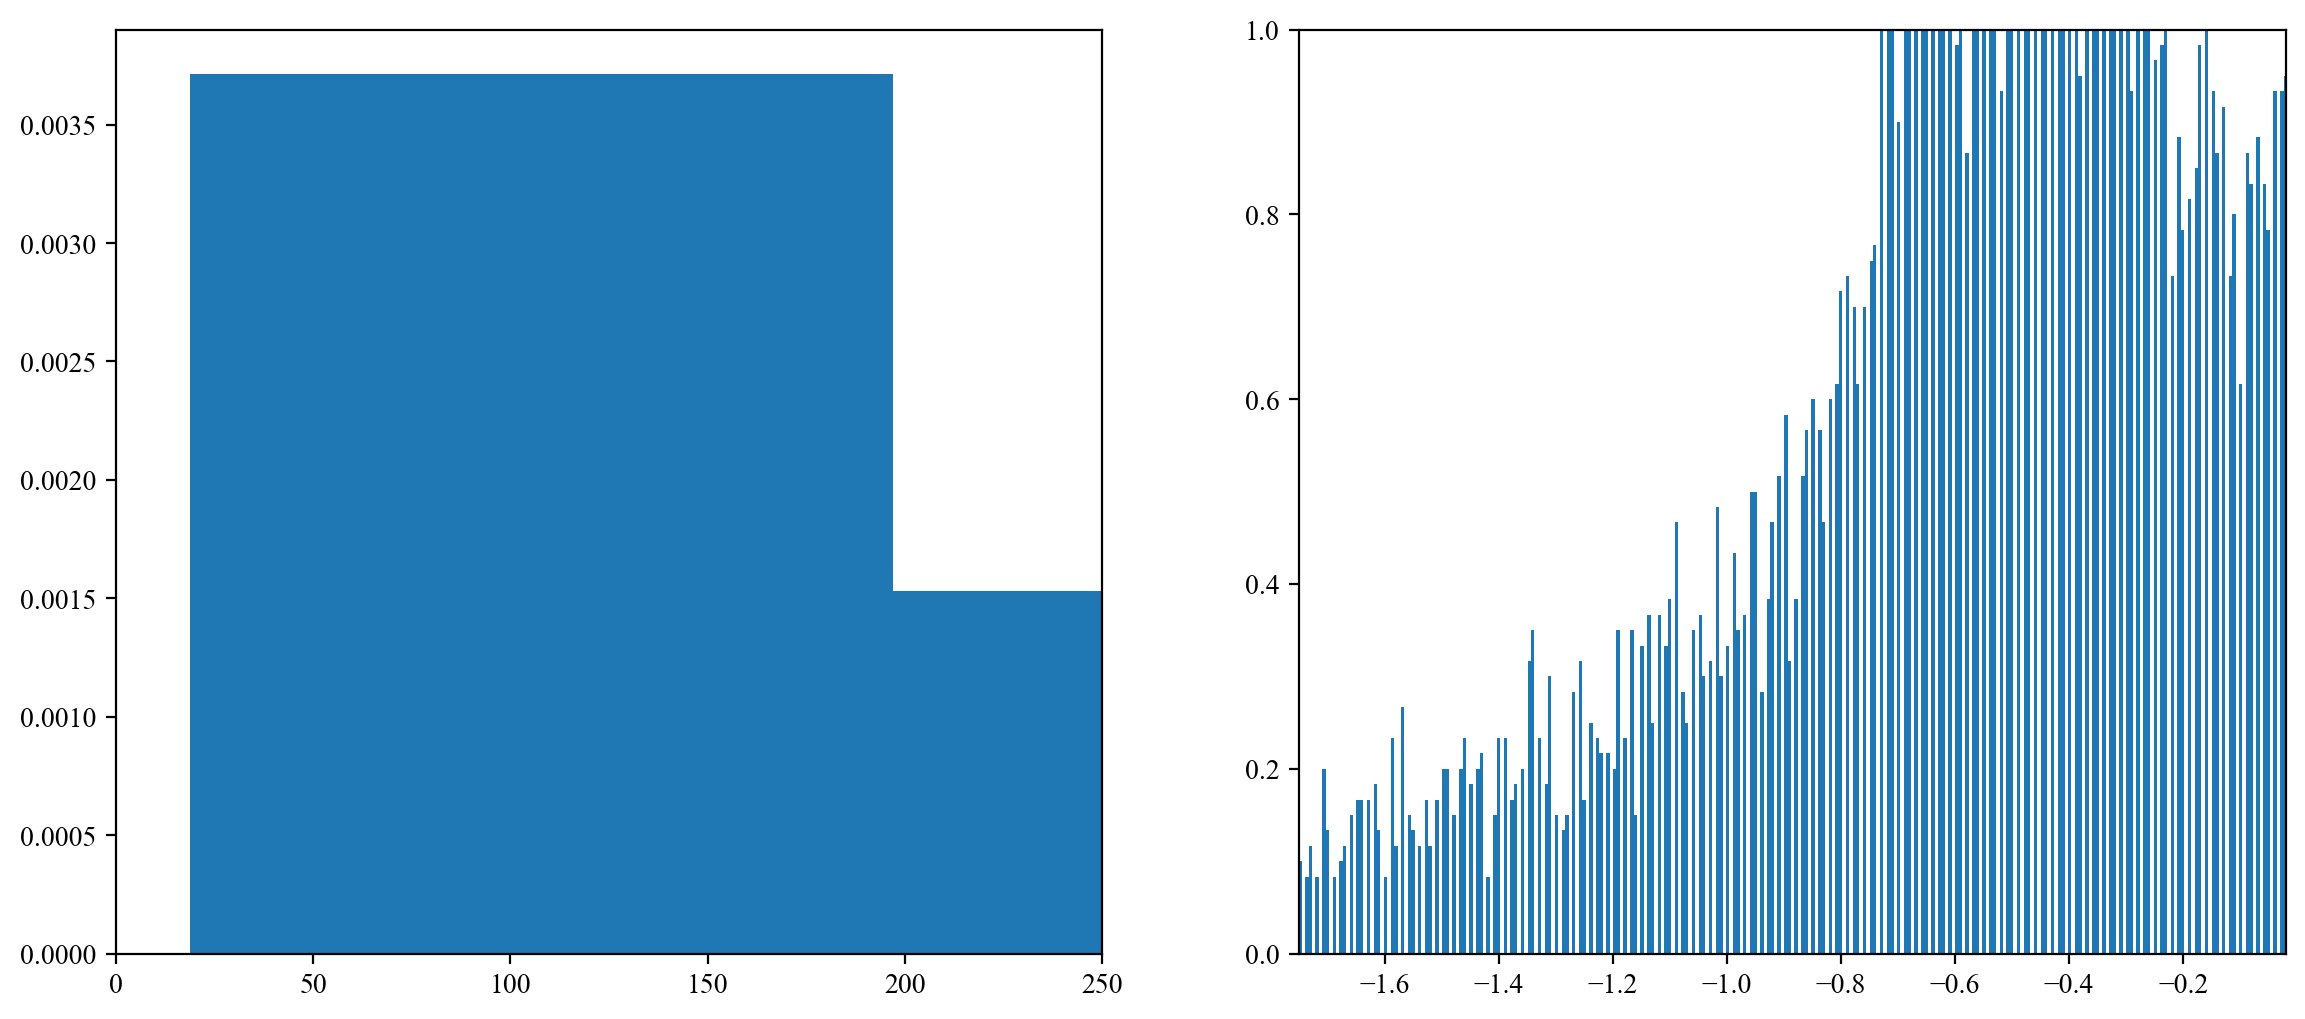

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6)) 
size=0.03
size_p = 2
alpha = 0.05
fontsize = 18

ax1.hist(min_dist_tr10NS, bins=5000, density=True)
ax1.set_xlim(0, 250)
ax2.hist(min_time_tr10NS.value, bins=500, density=True)
ax2.set_xlim(-1.75, -0.02)
ax2.set_ylim(0, 1)
plt.show()


In [199]:
np.median(min_time_tr10NS[min_time_tr10NS.value<-0.015]), np.percentile(min_time_tr10NS[min_time_tr10NS.value<-0.015], 2.5), np.percentile(min_time_tr10NS[min_time_tr10NS.value<-0.015], 97.5)

(<Quantity -0.57 Myr>, <Quantity -2.362 Myr>, <Quantity -0.05 Myr>)

In [205]:
np.median(ns_rv[min_time_tr10NS.value<-0.015]), np.percentile(ns_rv[min_time_tr10NS.value<-0.015], 2.5), np.percentile(ns_rv[min_time_tr10NS.value<-0.015], 97.5)

(-98.81324236302646, -477.7278537165993, 443.0864465449072)